### ------------------------------------------------------
#### CASE STUDY 5: 
### ------------------------------------------------------







### Use SVM and SGD to attempt to model and predict the class of an internet connection request. 

## target is action 
## everything else a feature 




### Imports

In [1]:
# from vowpalwabbit import vw -- couldnt get to download and work on the mac for the sake of time went the other route 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

import pandas as pd  
import sweetviz as sv

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, make_scorer

from sklearn.svm import SVC

In [2]:
# Load data logs2.csv

data = pd.read_csv('Data_Science/Case_Study5/log2.csv')  # Read only the first 10,000 rows
print(data.head())   

   Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0        57222                53            54587                    53   
1        56258              3389            56258                  3389   
2         6881             50321            43265                 50321   
3        50553              3389            50553                  3389   
4        50002               443            45848                   443   

  Action  Bytes  Bytes Sent  Bytes Received  Packets  Elapsed Time (sec)  \
0  allow    177          94              83        2                  30   
1  allow   4768        1600            3168       19                  17   
2  allow    238         118             120        2                1199   
3  allow   3327        1438            1889       15                  17   
4  allow  25358        6778           18580       31                  16   

   pkts_sent  pkts_received  
0          1              1  
1         10              9  
2 

In [3]:


print(data.columns)

rename_dict = {
    'Source Port': 'SourcePort',
    'Destination Port': 'DestinationPort',
    'NAT Source Port': 'NATS',
    'NAT Destination Port': 'NATD',
    'Bytes Sent': 'BytesSent',
    'Bytes Received': 'BytesReceived',
    'Elapsed Time (sec)': 'ElapsedTime',
    'pkts_sent': 'pktssent',
    'pkts_received': 'pktsrec',
}

data.rename(columns=rename_dict, inplace=True)

# To check the changes, you can print the DataFrame's info
data.info()
print(data.shape)
print(data.dtypes)
print(data.info())

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SourcePort       65532 non-null  int64 
 1   DestinationPort  65532 non-null  int64 
 2   NATS             65532 non-null  int64 
 3   NATD             65532 non-null  int64 
 4   Action           65532 non-null  object
 5   Bytes            65532 non-null  int64 
 6   BytesSent        65532 non-null  int64 
 7   BytesReceived    65532 non-null  int64 
 8   Packets          65532 non-null  int64 
 9   ElapsedTime      65532 non-null  int64 
 10  pktssent         65532 non-null  int64 
 11  pktsrec          65532 non-null  int64 
dtypes: int64(11),

Convert categorical data into the correct data type 

In [4]:
# Need to convert ports to categorical data

change_cols = ['SourcePort', 'DestinationPort', 'NATS', 'NATD', 'Action']
for col in change_cols:
    data[col] = data[col].astype('category')
    
print(data.info())
# need to convert NATS to categorical 
# then need to scale 

# Split the data into features and target
target_full = data['Action']
features_full = data.drop('Action', axis=1)
print(features_full.head())
print(target_full.head())
print(features_full.shape)
print(target_full.shape)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SourcePort       65532 non-null  category
 1   DestinationPort  65532 non-null  category
 2   NATS             65532 non-null  category
 3   NATD             65532 non-null  category
 4   Action           65532 non-null  category
 5   Bytes            65532 non-null  int64   
 6   BytesSent        65532 non-null  int64   
 7   BytesReceived    65532 non-null  int64   
 8   Packets          65532 non-null  int64   
 9   ElapsedTime      65532 non-null  int64   
 10  pktssent         65532 non-null  int64   
 11  pktsrec          65532 non-null  int64   
dtypes: category(5), int64(7)
memory usage: 6.2 MB
None
  SourcePort DestinationPort   NATS   NATD  Bytes  BytesSent  BytesReceived  \
0      57222              53  54587     53    177         94             83   
1      56258       

Reduced Data 10k use for hyperparatmer tuning. 

Final Model use complete dataset. 

SKLEARN SVM (linearSVC and Linear Classifier) traditionally use -1 and 1 for binary classifier, but sklearns implementation internally handles 0 and 1 encoding just fine. 

SGD with sklearn has no issue working with binary classifier 1 and 0. 



Because the idea was to keep the data from getting to wide, we use stratified scaler transformation before reducing it to just a random collection of 10000 samples to use for hyperparameter tuning. 

We use the package Startify to startify our data before reducing it to 10k samples. 

the final model will use SVMCLASSIFIER, the selected hyperparameters, and the full dataset

Lets look at the number of features first with Sweetviz - create cutoffs for those that are outliers to reduce the dimensions 

                                             |                                                                …


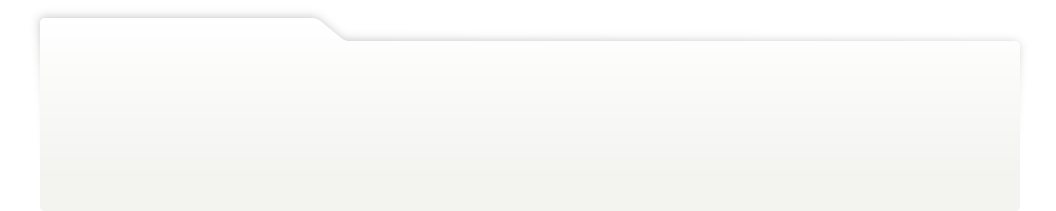
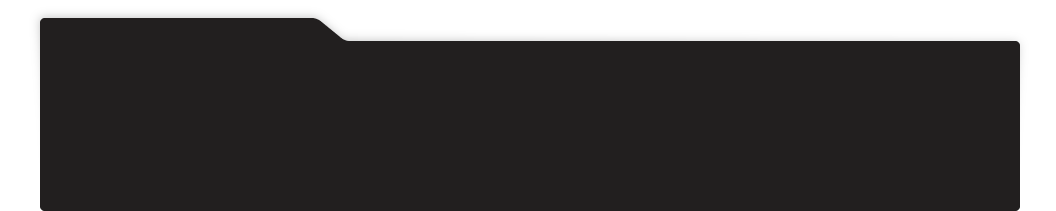
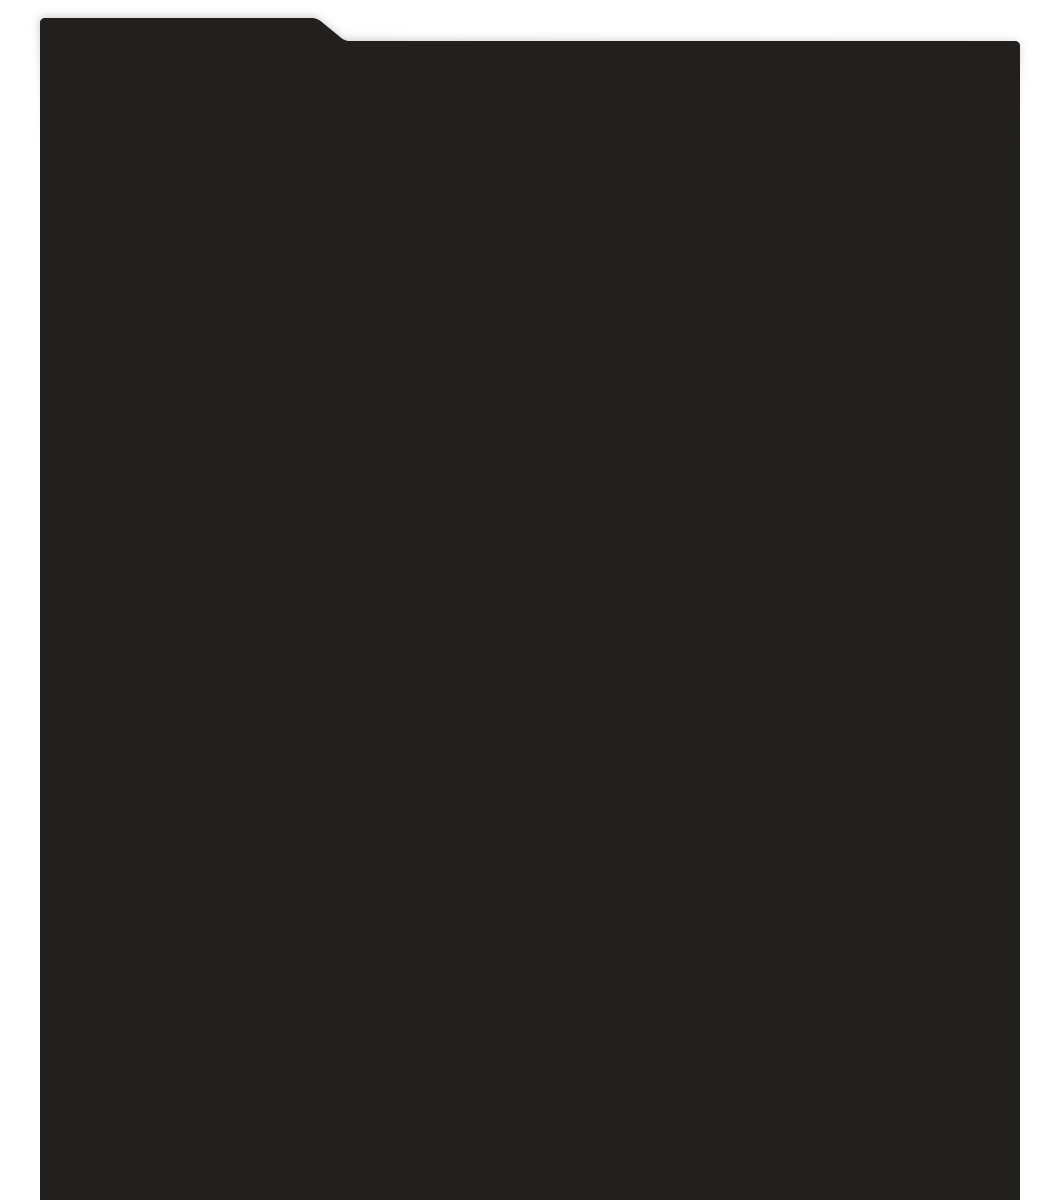
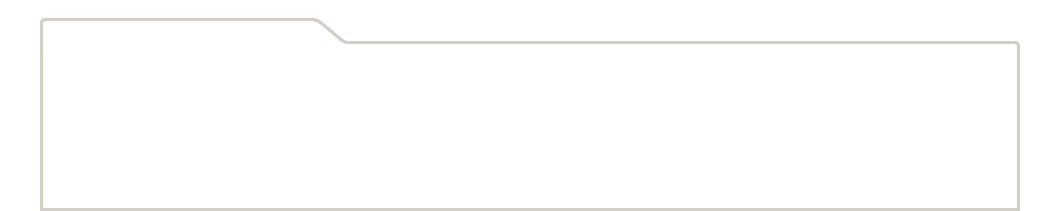
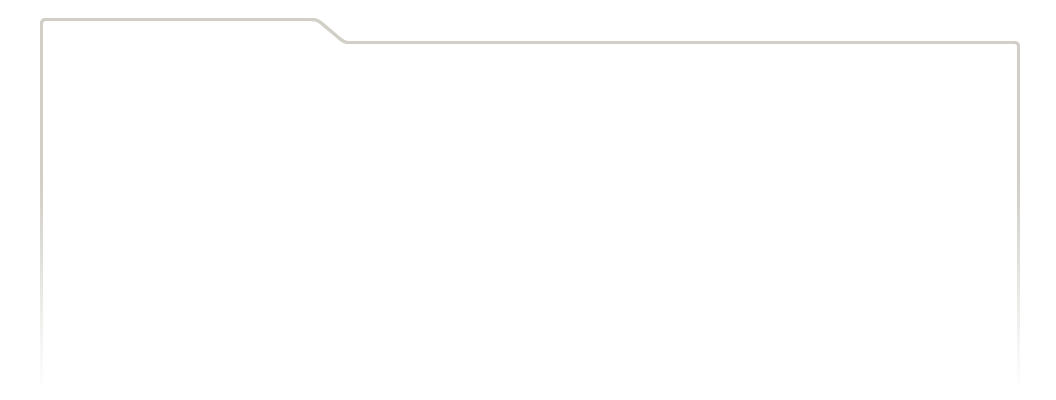
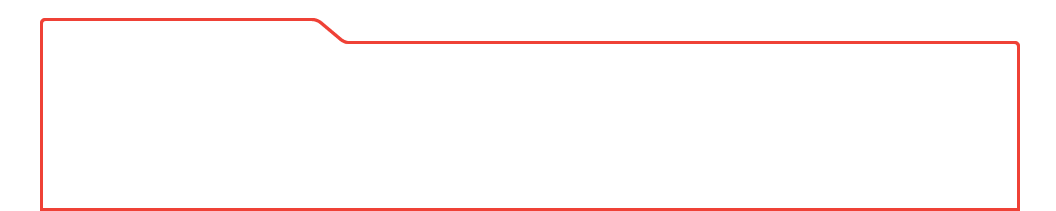
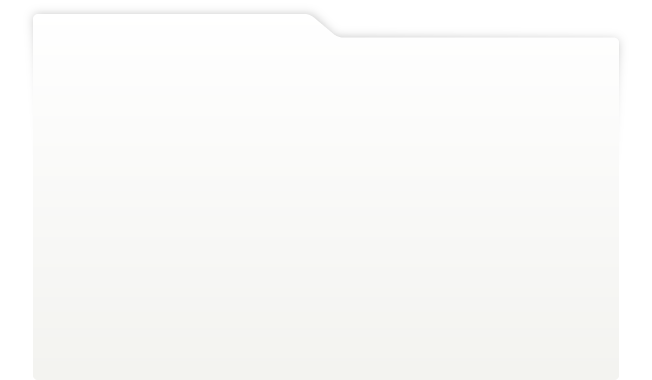
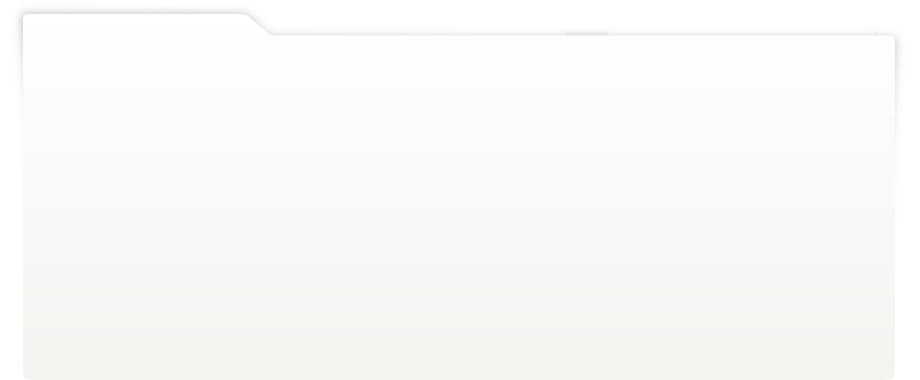
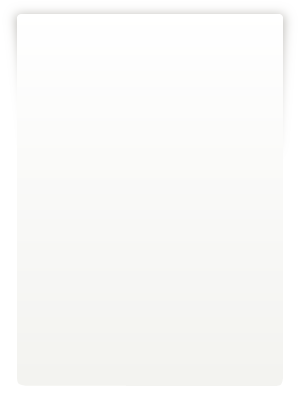
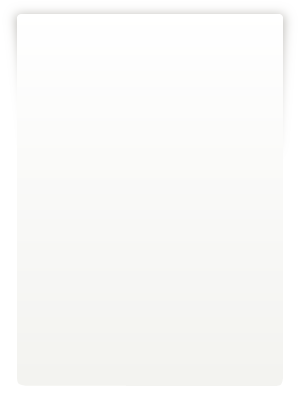
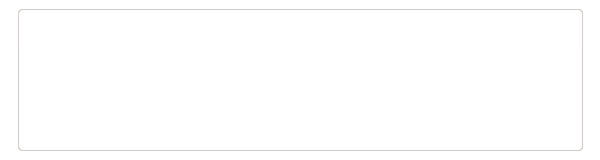
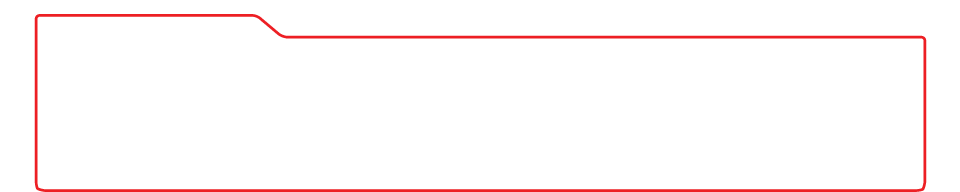
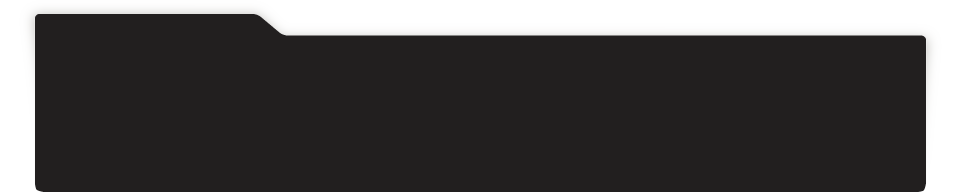
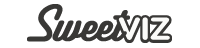
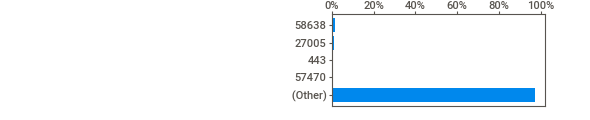
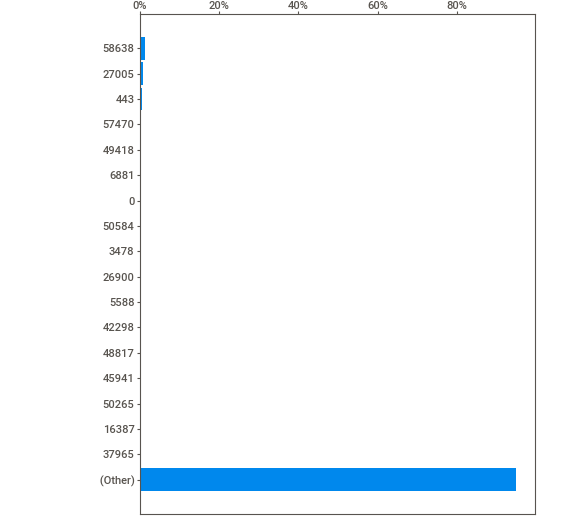
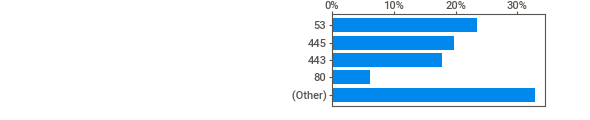
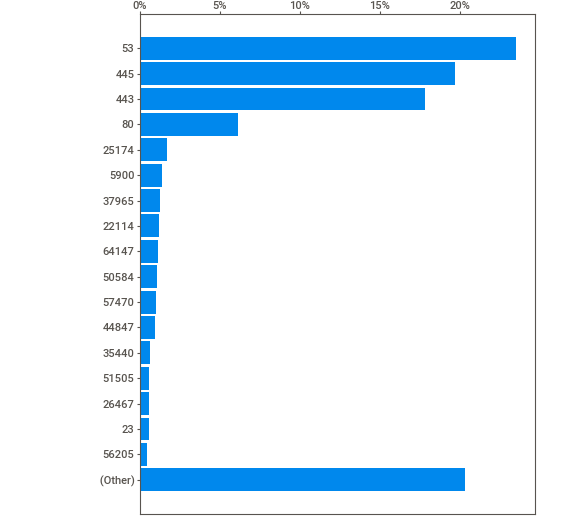
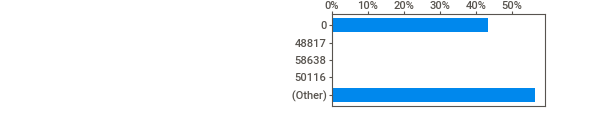
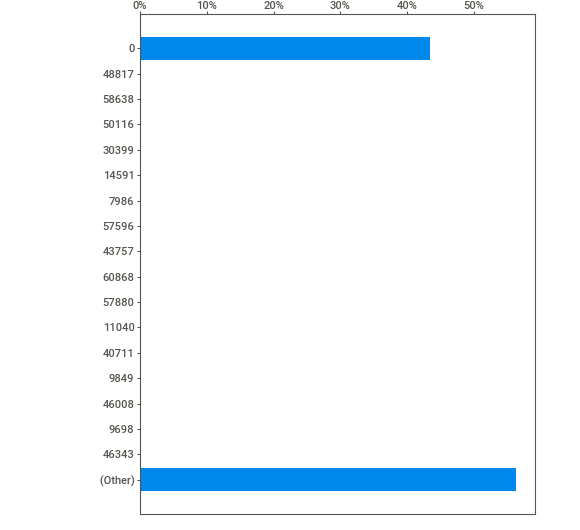
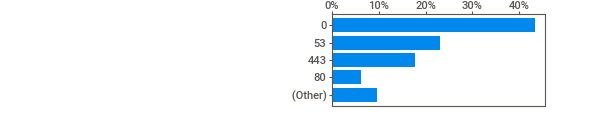
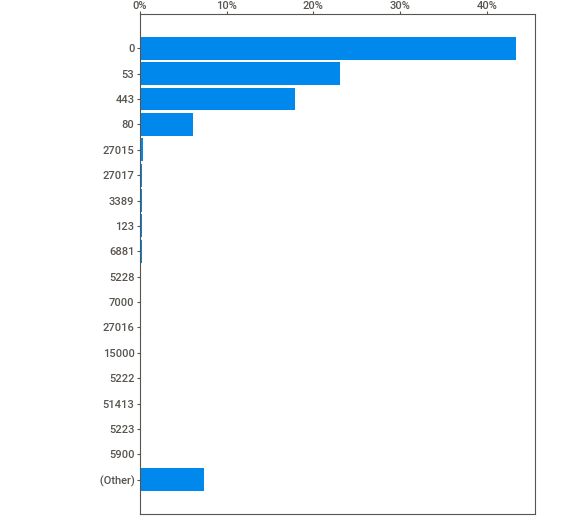
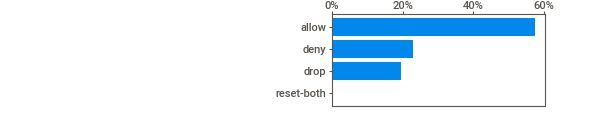
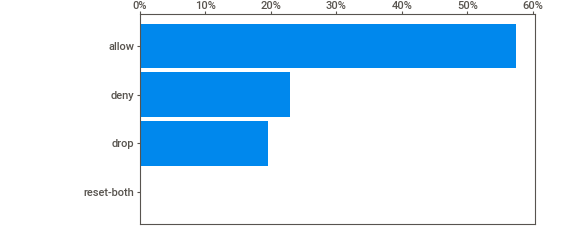
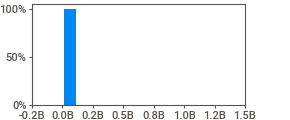
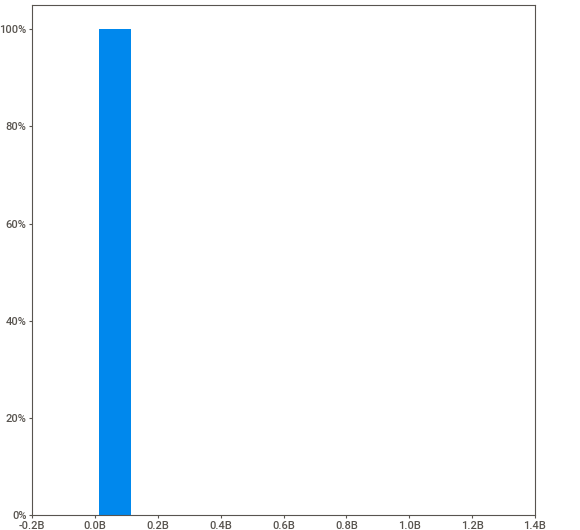
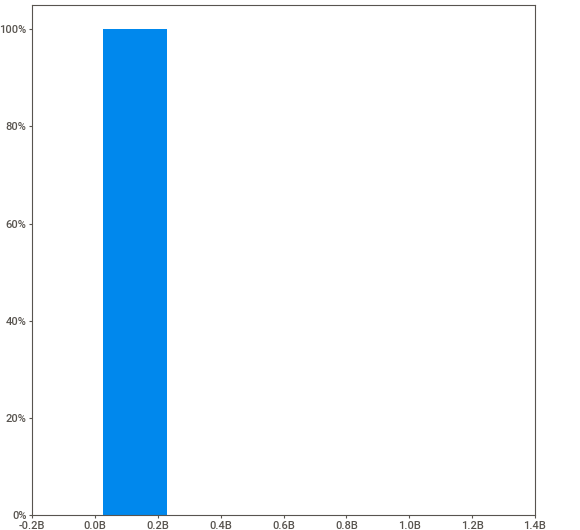
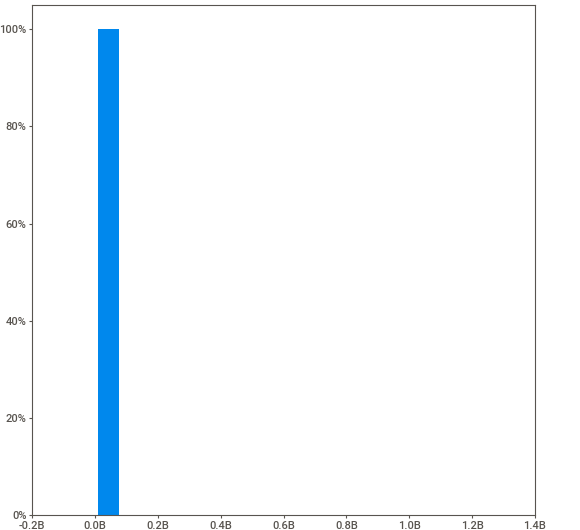
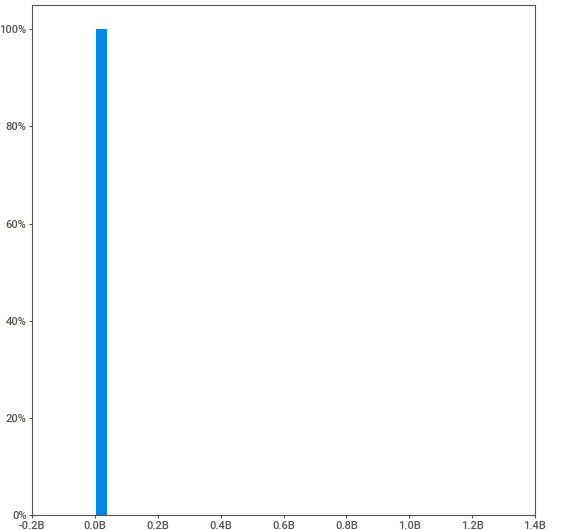
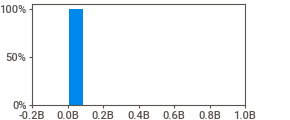
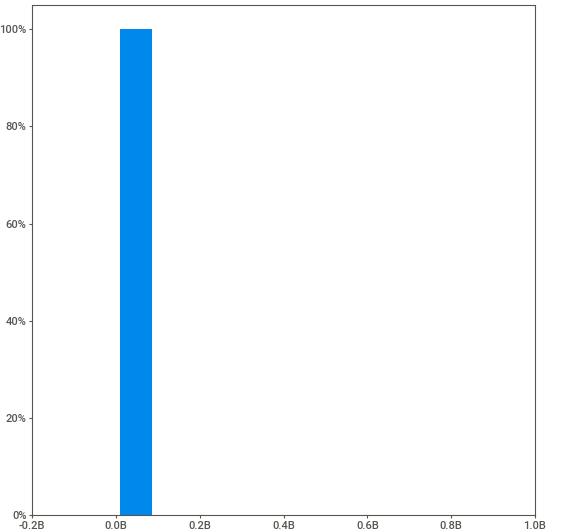
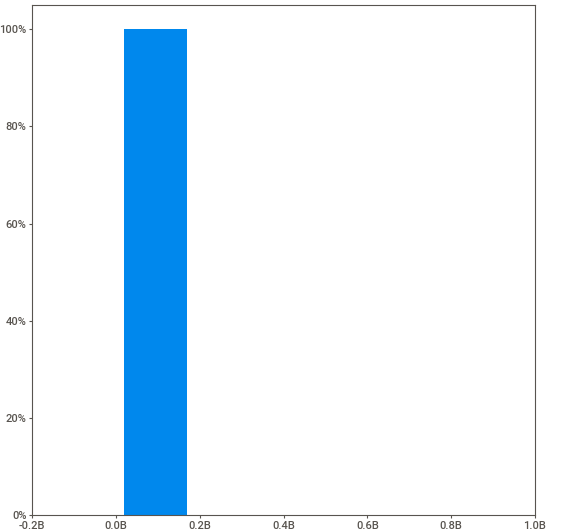
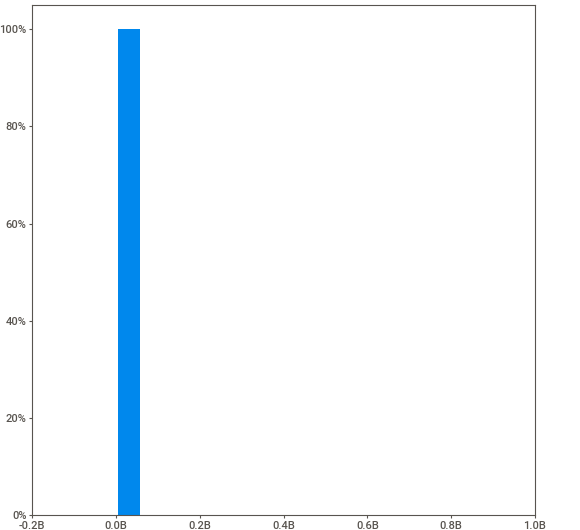
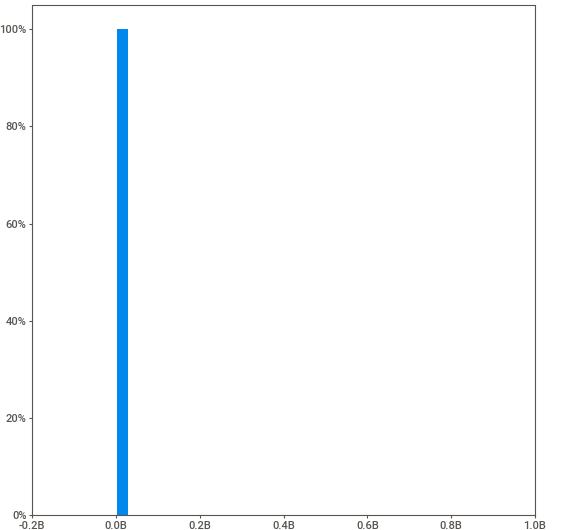
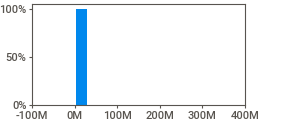
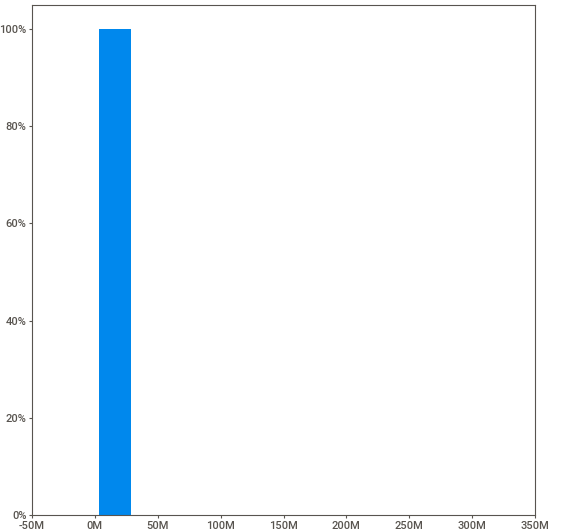
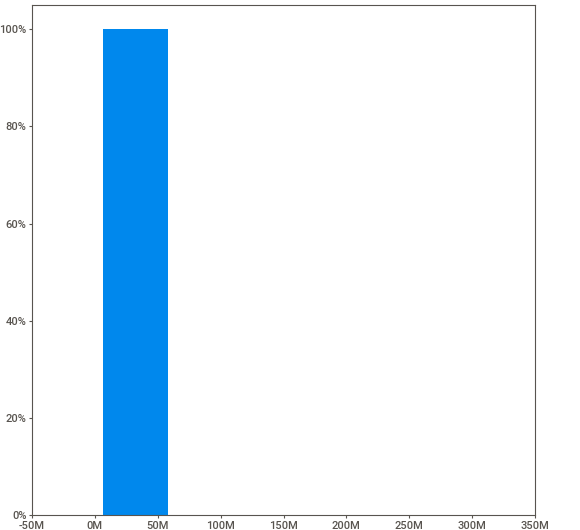
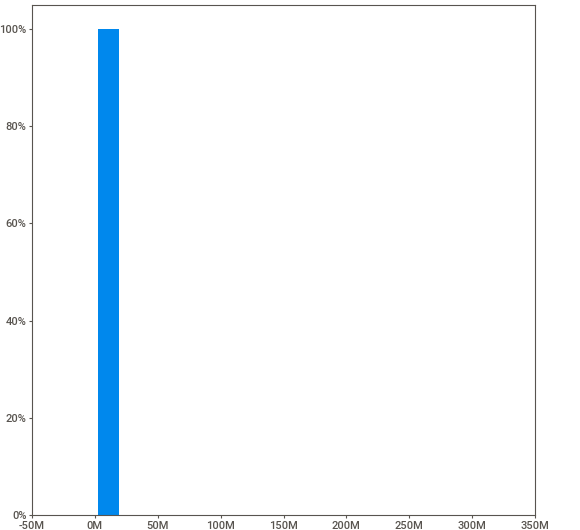
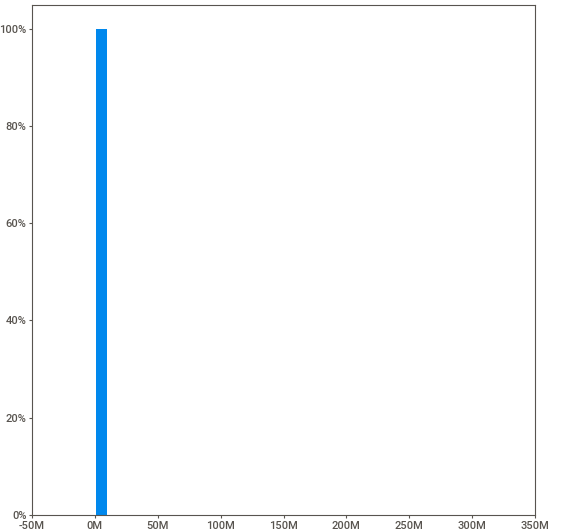
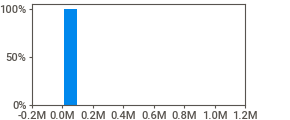
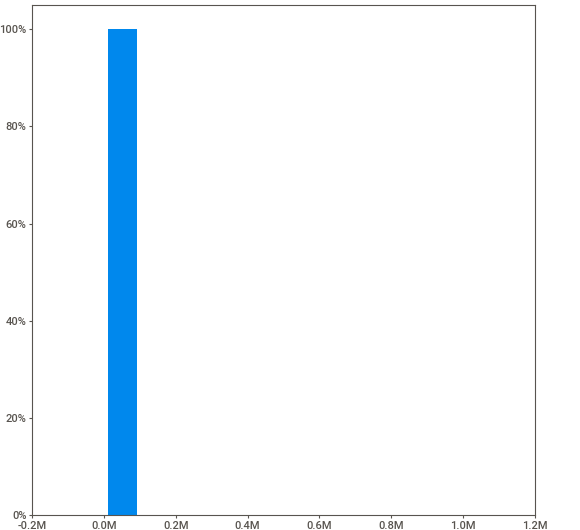
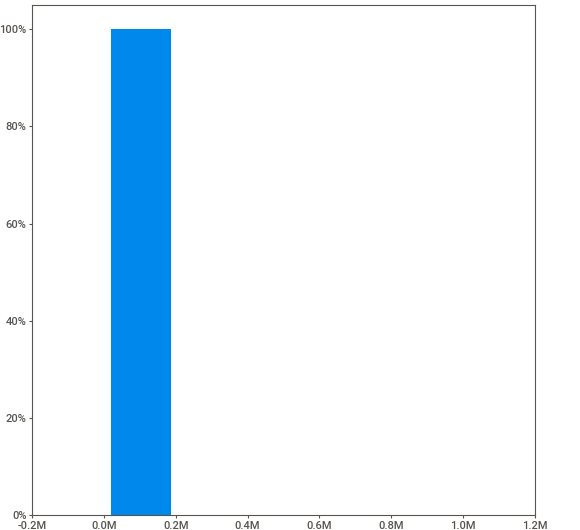
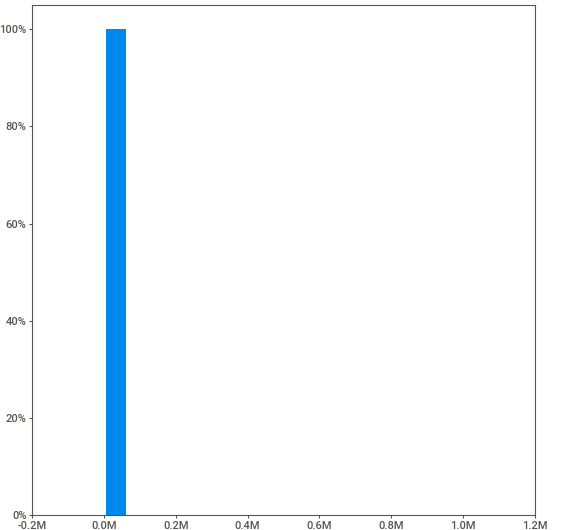
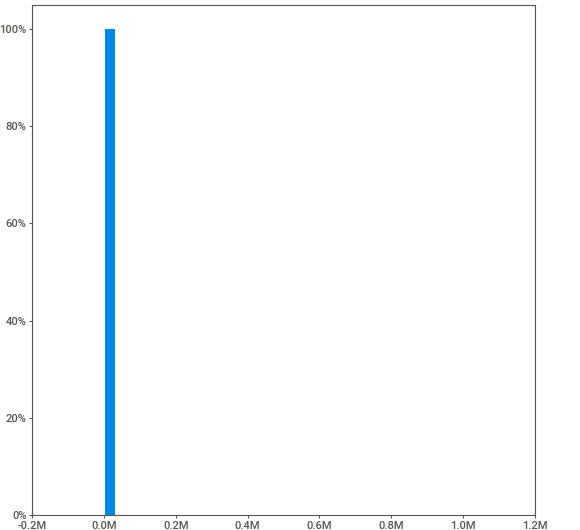
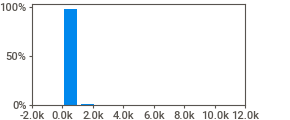
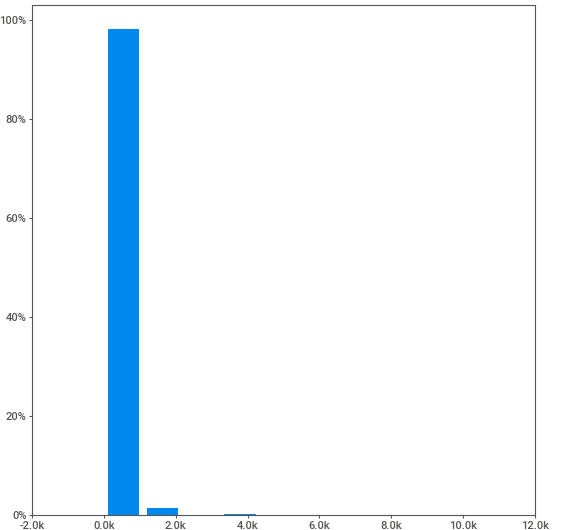
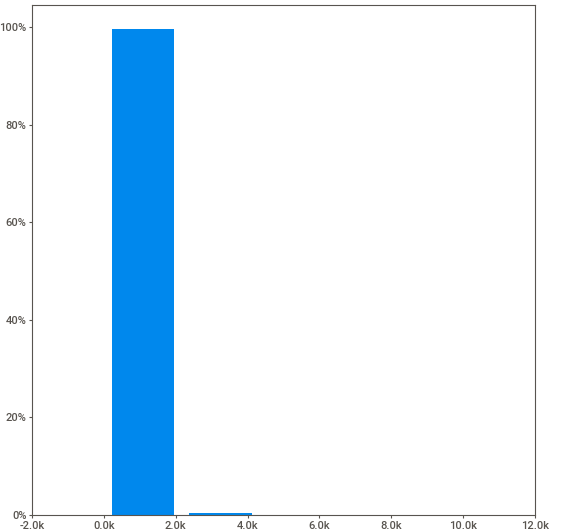
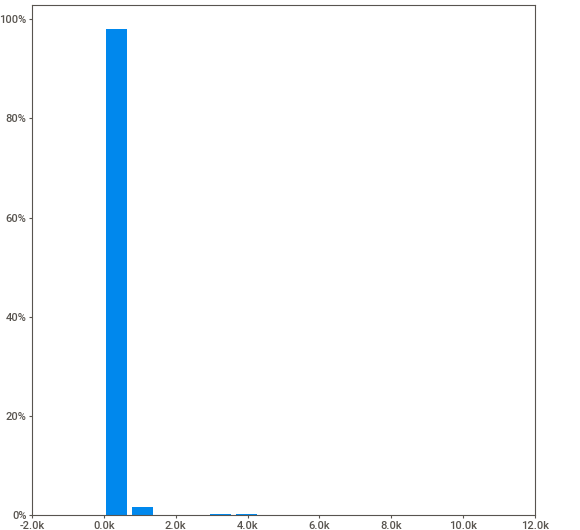
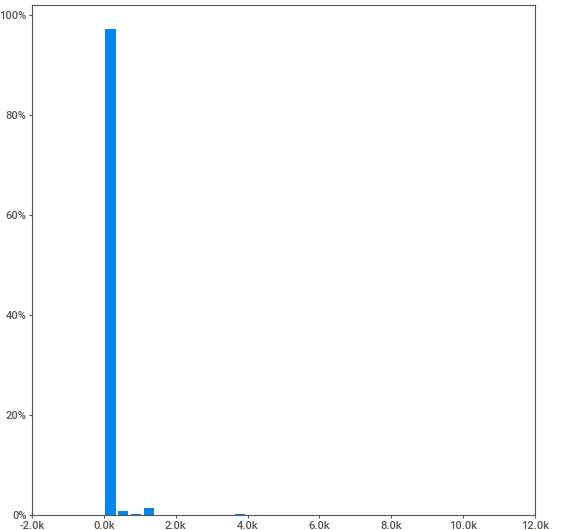
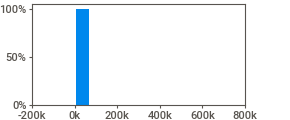
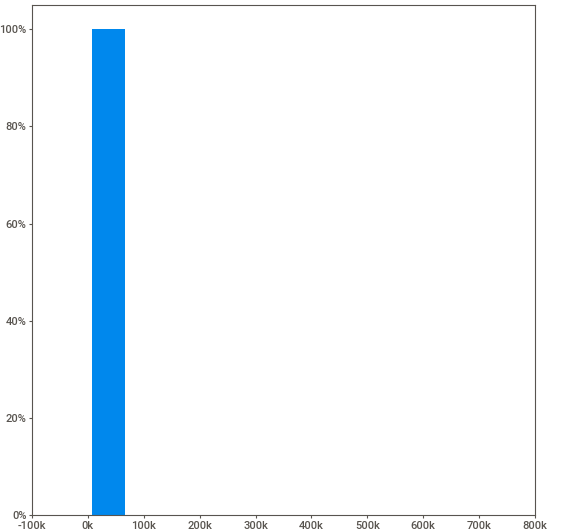
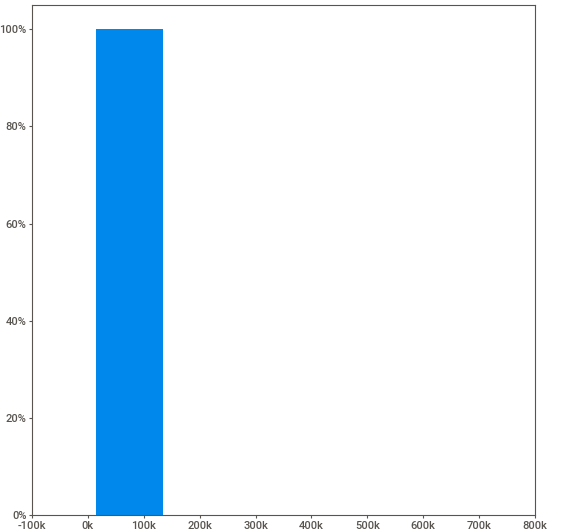
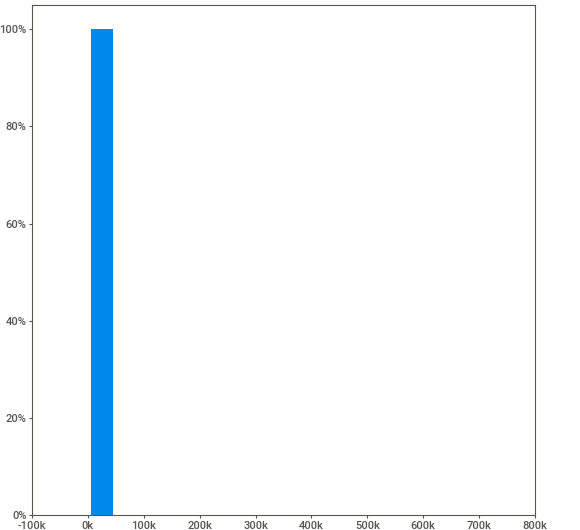
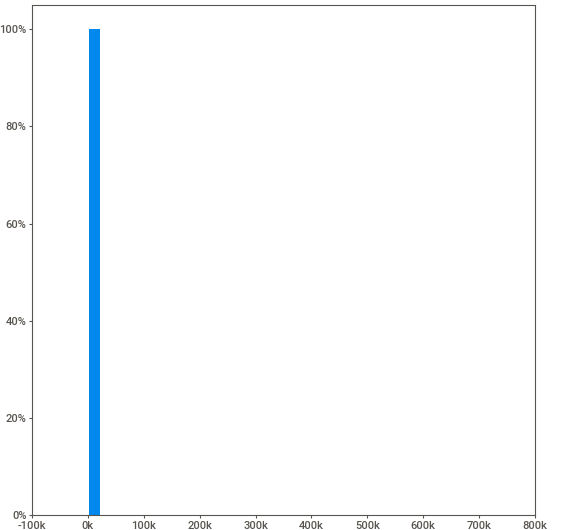
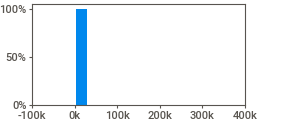
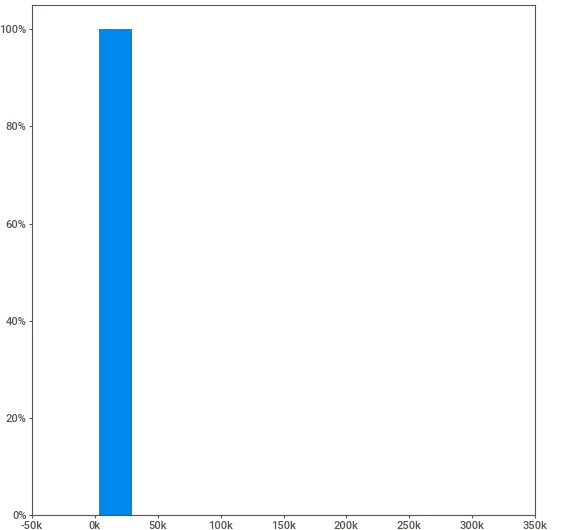
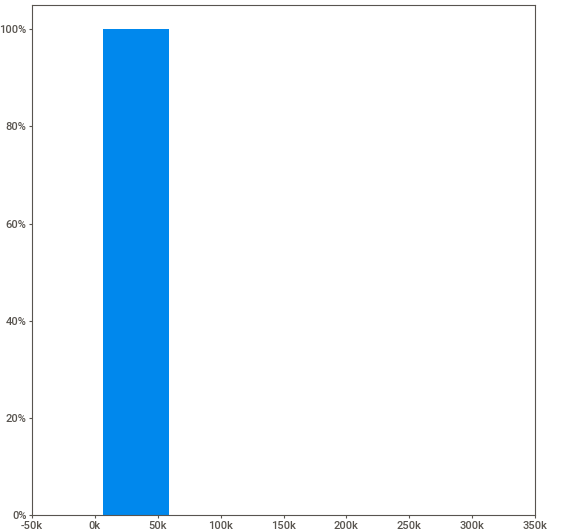
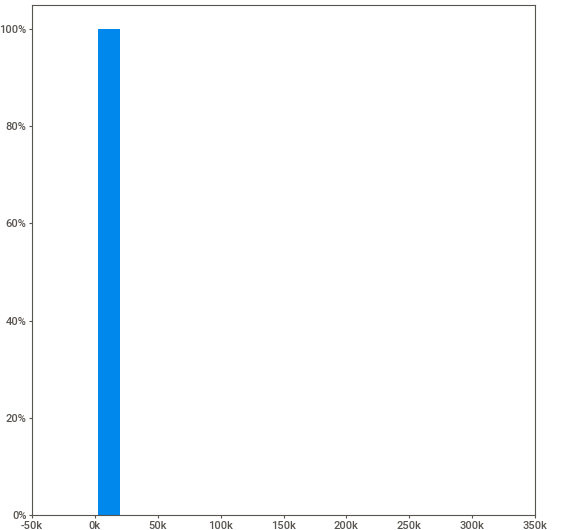
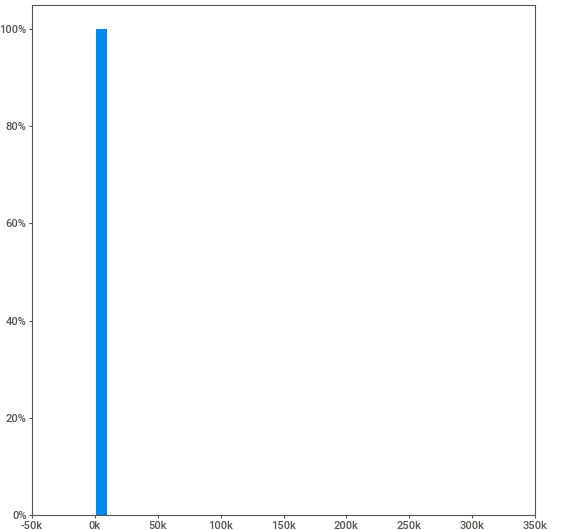
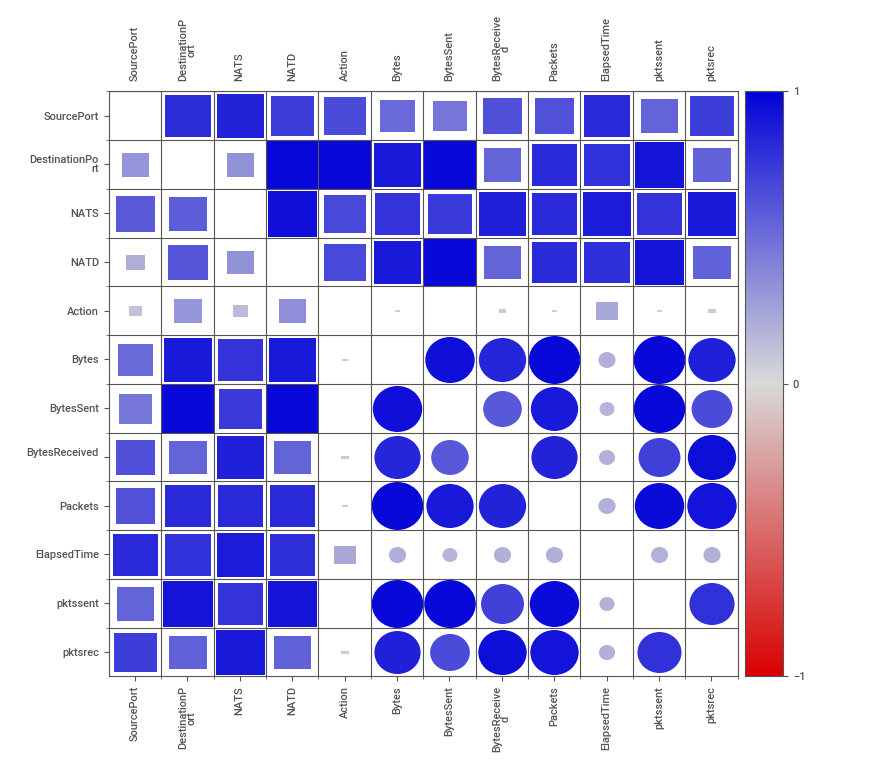
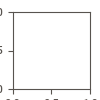

In [52]:
# FULL DATASET 

report = sv.analyze(data)
report.show_notebook()

In [5]:
####### CREATE A COPY OF ORIGINAL DATA FOR IMPUTING ########
# Create a copy of the original data
data_copy = data.copy()


1 Source Port: Categorical in nature but has 22k distinct values and vast majority were an "other" category and everything else was 1% or less. To prevent the data from getting to wide the column was categorized into Rare and Common so that we can create a binary 0/1 hot encoding and not widen our dataset unnessarily. 

In [6]:
# Create categories for Source Port 
# IT has 22k unique values and the distribution is skewed to "Other". Creating three categories for Source Port: Other, <1% and 1%


# Calculate the frequency of each unique value
value_counts = data_copy['SourcePort'].value_counts()
# print(value_counts)
# Calculate the percentage of occurrences for each value
value_percentages = value_counts / len(data_copy) * 100
# print(value_percentages)

# Create categories for Source Port 
# IT has 22k unique values and the distribution is skewed to "Other". Creating three categories for Source Port: Other, <1% and 1%

threshold = 1
# Create a mapping dictionary
mapping = {value: ('rare' if percentage >= threshold else 'Other') for value, percentage in value_percentages.items()}

# Apply the mapping to the SourcePort column
data_copy['SourcePort'] = data_copy['SourcePort'].map(mapping)
print(data_copy['SourcePort'].value_counts(normalize=True))
print(data_copy['SourcePort'].unique())


SourcePort
Other    0.987182
rare     0.012818
Name: proportion, dtype: float64
['Other' 'rare']



2 Destination Port: Categorical in nature but has ~3k distinct values. The sprad seemed to indicate 5 categories were manageable with the 4 highest having their own categories and everything else sub <5%. 

In [7]:


# categories
specific_categories = ['53', '445', '443', '80']
# rare_categories = ['25174','5900', '37965', '22144', '64147', '50584', '57470', '44847', '35440', '51505', '26467']

value_counts = data_copy['DestinationPort'].value_counts()
# print(value_counts)
value_percentages = value_counts / len(data_copy) * 100
# print(value_percentages)
threshold = 1
# Create a mapping function
def categorize_destination(value):
    value_str = str(value).lower()  # Convert to lowercase for case-insensitive comparison
    if value_str in specific_categories:
        return value_str
    elif value_percentages.get(value, 0) >= threshold and value_str not in specific_categories:
        return 'other'
    else:
        return 'other'

# Apply the mapping to the DestinationPort column
data_copy['DestinationPort'] = data_copy['DestinationPort'].apply(categorize_destination)


data_copy['DestinationPort'] = pd.Categorical(data_copy['DestinationPort'])

print(data_copy['DestinationPort'].value_counts(normalize=True))
print(data_copy['DestinationPort'].unique())
print(data_copy['DestinationPort'].dtype)
print(f"Number of categories: {data_copy['DestinationPort'].nunique()}")

DestinationPort
other    0.328206
53       0.235213
445      0.196713
443      0.178295
80       0.061573
Name: proportion, dtype: float64
['53', 'other', '443', '80', '445']
Categories (5, object): ['443', '445', '53', '80', 'other']
category
Number of categories: 5


3 NAT Source Port: Categorical in nature but has ~29k distinct values. 3 categories selected 

In [8]:

# Calculate the frequency of each unique value
value_counts = data_copy['NATS'].value_counts()
# print(value_counts)
# Calculate the percentage of occurrences for each value
value_percentages = value_counts / len(data_copy) * 100
# print(value_percentages)

# Create categories for Source Port 
# IT has 22k unique values and the distribution is skewed to "Other". Creating three categories for Source Port: Other, <1% and 1%

threshold = 1
# Create a mapping dictionary
mapping = {value: ('0' if percentage >= threshold else 'Other') for value, percentage in value_percentages.items()}

# Apply the mapping to the SourcePort column
data_copy['NATS'] = data_copy['NATS'].map(mapping)
print(data_copy['NATS'].value_counts(normalize=True))
print(data_copy['NATS'].unique())


NATS
Other    0.566136
0        0.433864
Name: proportion, dtype: float64
['Other' '0']


4 NAT Desintation Port: Categorical in nature but has ~29k distinct values. 3 categories selected 

In [9]:


# categories
specific_categories = ['0', '53', '443', '80']
# rare_categories = ['25174','5900', '37965', '22144', '64147', '50584', '57470', '44847', '35440', '51505', '26467']

value_counts = data_copy['NATD'].value_counts()
# print(value_counts)
value_percentages = value_counts / len(data_copy) * 100
# print(value_percentages)
threshold = 1
# Create a mapping function
def categorize_destination(value):
    value_str = str(value).lower()  # Convert to lowercase for case-insensitive comparison
    if value_str in specific_categories:
        return value_str
    elif value_percentages.get(value, 0) >= threshold and value_str not in specific_categories:
        return 'other'
    else:
        return 'other'

# Apply the mapping to the DestinationPort column
data_copy['NATD'] = data_copy['NATD'].apply(categorize_destination)


data_copy['NATD'] = pd.Categorical(data_copy['NATD'])

print(data_copy['NATD'].value_counts(normalize=True))
print(data_copy['NATD'].unique())
print(data_copy['NATD'].dtype)
print(f"Number of categories: {data_copy['NATD'].nunique()}")

NATD
0        0.433864
53       0.230330
443      0.178203
other    0.096136
80       0.061466
Name: proportion, dtype: float64
['53', 'other', '443', '80', '0']
Categories (5, object): ['0', '443', '53', '80', 'other']
category
Number of categories: 5


SCALE, test train split, then target split full data

In [10]:
######### FOR FULL DATASET #########
# Split the data into features and target
target = data_copy['Action']
features = data_copy.drop('Action', axis=1)
print(target.shape)
print(features.shape)
target.head()
features.head()

## Label Encode the target variable 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(target)
y_encoded.shape



(65532,)
(65532, 11)


(65532,)

In [11]:
# one hot encode the categorical data types in features 
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SourcePort       65532 non-null  object  
 1   DestinationPort  65532 non-null  category
 2   NATS             65532 non-null  object  
 3   NATD             65532 non-null  category
 4   Bytes            65532 non-null  int64   
 5   BytesSent        65532 non-null  int64   
 6   BytesReceived    65532 non-null  int64   
 7   Packets          65532 non-null  int64   
 8   ElapsedTime      65532 non-null  int64   
 9   pktssent         65532 non-null  int64   
 10  pktsrec          65532 non-null  int64   
dtypes: category(2), int64(7), object(2)
memory usage: 4.6+ MB


In [12]:
# Convert 'SourcePort' and 'NATSource' to categorical
features['SourcePort'] = pd.Categorical(features['SourcePort'])
features['NATS'] = pd.Categorical(features['NATS'])
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SourcePort       65532 non-null  category
 1   DestinationPort  65532 non-null  category
 2   NATS             65532 non-null  category
 3   NATD             65532 non-null  category
 4   Bytes            65532 non-null  int64   
 5   BytesSent        65532 non-null  int64   
 6   BytesReceived    65532 non-null  int64   
 7   Packets          65532 non-null  int64   
 8   ElapsedTime      65532 non-null  int64   
 9   pktssent         65532 non-null  int64   
 10  pktsrec          65532 non-null  int64   
dtypes: category(4), int64(7)
memory usage: 3.8 MB


In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Separate categorical and numerical columns based on dtype
categorical_cols = features.select_dtypes(include=['category']).columns  # Changed to just 'category'
numeric_cols = features.select_dtypes(include=['int64']).columns        # Specifically 'int64'

# Create transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 
numeric_transformer = StandardScaler()

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols),
    ])

# Apply the preprocessing
encoded_features = preprocessor.fit_transform(features)

# Convert to DataFrame for better readability (optional)
encoded_features_df = pd.DataFrame(encoded_features, columns=preprocessor.get_feature_names_out())

print(encoded_features_df.head().to_markdown(index=False, numalign="left", stralign="left"))


| cat__SourcePort_Other   | cat__SourcePort_rare   | cat__DestinationPort_443   | cat__DestinationPort_445   | cat__DestinationPort_53   | cat__DestinationPort_80   | cat__DestinationPort_other   | cat__NATS_0   | cat__NATS_Other   | cat__NATD_0   | cat__NATD_443   | cat__NATD_53   | cat__NATD_80   | cat__NATD_other   | num__Bytes   | num__BytesSent   | num__BytesReceived   | num__Packets   | num__ElapsedTime   | num__pktssent   | num__pktsrec   |
|:------------------------|:-----------------------|:---------------------------|:---------------------------|:--------------------------|:--------------------------|:-----------------------------|:--------------|:------------------|:--------------|:----------------|:---------------|:---------------|:------------------|:-------------|:-----------------|:---------------------|:---------------|:-------------------|:----------------|:---------------|
| 1                       | 0                      | 0                          | 0             

STOP HERE - for SGD and skip down to SGD section 

In [17]:
from sklearn.model_selection import train_test_split
x_large, x_small, y_large, y_small = train_test_split(encoded_features_df, y_encoded, test_size=0.2, random_state=42)
print(x_large.shape)
print(y_large.shape)
print(x_small.shape)
print(y_small.shape)

(52425, 21)
(52425,)
(13107, 21)
(13107,)


In [20]:
# Use Xtest and ytest the smaller of the two to hyper parameter tune -- 

from sklearn.svm import LinearSVC
# x_train
# y_train
penalty='l2'
loss='hinge'
dual = False
tol=0.0001
C=1.0
multi_class='ovr'
random_state=42
max_iter=1000

# kernal, C 
# 
my_model = LinearSVC(C=1.0, penalty='l2', loss='hinge', dual='auto', multi_class='ovr', random_state=42, max_iter=1000)
my_model.fit(x_large, y_large)
my_model.predict(x_small)

# from sklearn.metrics import accuracy_score
# accuracy_score(my_model.predict(x_small), y_small) # 1.0

from sklearn.model_selection import cross_val_score
# cross_val_score(my_model, x_large, y_large, cv=5, scoring='accuracy')

accuracies = {}
# for i in [1E-3, 1E-2, 1E-1, 1, 1E1, 1E2, 1E3]:
for i in [1E-1, 1E-5, 1E1, 1E3, 1E5]:
    my_model.C = i # smaller C means more regularization in SVC 
    print(i, cross_val_score(my_model, x_large, y_large, cv=5, scoring='accuracy').mean())
    accuracies[i] = cross_val_score(my_model, x_large, y_large, cv=5, scoring='accuracy').mean()


/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.1 0.9950023843586076
1e-05 0.5860944206008584


/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


10.0 0.9968144969003339


/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/User

1000.0 0.9968717215069146


/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/User

100000.0 0.9968717215069146


/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Best C value: 1000.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7545
           1       0.99      1.00      1.00      2994
           2       1.00      1.00      1.00      2562
           3       0.00      0.00      0.00         6

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107



/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:15

<Figure size 1000x800 with 0 Axes>

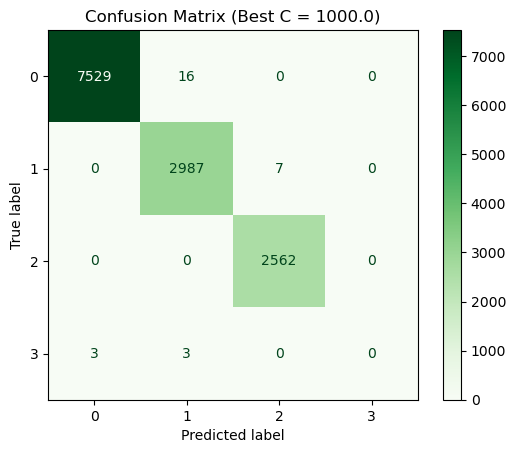

In [21]:
import matplotlib.pyplot as plt
# Find the best C value
best_C = max(accuracies, key=accuracies.get)
print(f"\nBest C value: {best_C}")

# Train the model with the best C value
best_model = LinearSVC(C=best_C, penalty='l2', loss='hinge', dual='auto', multi_class='ovr', random_state=42, max_iter=1000)
best_model.fit(x_large, y_large)

# Make predictions on the test set
y_pred = best_model.predict(x_small)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_small, y_pred))

# Create and display the confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_small, y_pred, cmap='Greens')
plt.title(f'Confusion Matrix (Best C = {best_C})')
plt.show()

In [ ]:
# So we figured out Regularlization parameter on a test train split. Now For final model we will tune for the gamma, rbf, poly, degree 2nd 3rd -- and use full dataset set with reg parameter of 1000 

Best parameters: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.9976348980874128

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7545
           1       0.99      1.00      1.00      2994
           2       1.00      1.00      1.00      2562
           3       0.00      0.00      0.00         6

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107



/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

<Figure size 1000x800 with 0 Axes>

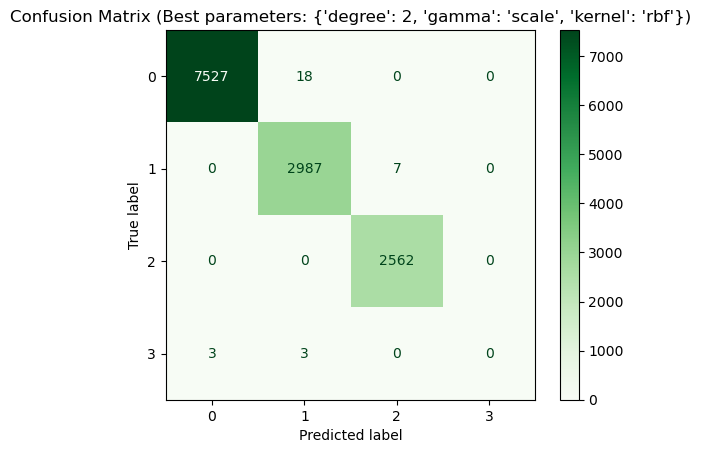

In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3]  # Only used when kernel='poly'
}

# Create the SVC model
svc = SVC(C=1000, decision_function_shape='ovr', random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(x_small, y_small)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(x_small)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_small, y_pred))

# Create and display the confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_small, y_pred, cmap='Greens')
plt.title(f'Confusion Matrix (Best parameters: {grid_search.best_params_})')
plt.show()

Cross-validation mean accuracy: 0.9970 (+/- 0.0000)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37640
           1       0.99      1.00      0.99     14987
           2       1.00      1.00      1.00     12851
           3       0.00      0.00      0.00        54

    accuracy                           1.00     65532
   macro avg       0.75      0.75      0.75     65532
weighted avg       1.00      1.00      1.00     65532



/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

<Figure size 1000x800 with 0 Axes>

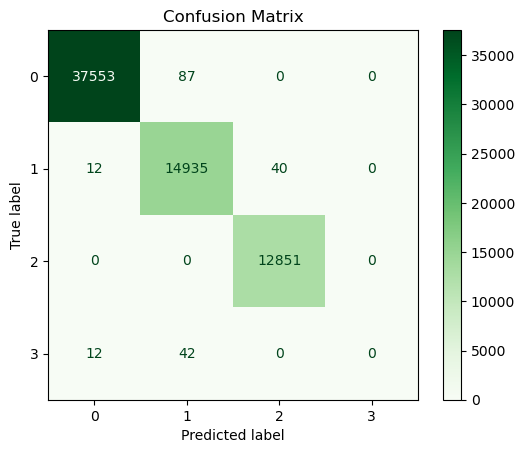

In [46]:
# Best parameters: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
import matplotlib.pyplot as plt
# Find the best C value
# best_C = max(accuracies, key=accuracies.get)
# print(f"\nBest C value: {best_C}")

# Train the model with the best C value
# best_model = LinearSVC(C=best_C, penalty='l2', loss='squared_hinge', dual='auto', multi_class='ovr', random_state=42, max_iter=1000)
# (encoded_features_df, y_encoded,

best_model = SVC(C=1000, decision_function_shape='ovr', gamma='scale', kernel='rbf', random_state=42)

cv_scores = cross_val_score(best_model, encoded_features_df, y_encoded, cv=5, scoring='accuracy').mean()
print(f"Cross-validation mean accuracy: {cv_scores.mean():.4f}")

best_model.fit(encoded_features_df, y_encoded)

# Make predictions on the test set
y_pred = best_model.predict(encoded_features_df)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_encoded, y_pred))

# Create and display the confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_encoded, y_pred, cmap='Greens')
plt.title(f'Confusion Matrix')
plt.show()

In [22]:
# Now watch mod 10 live session and run sgdclassifier on Sunday 


print(encoded_features_df.shape)
print(y_encoded.shape)



from sklearn.linear_model import SGDClassifier




(65532, 21)
(65532,)


In [ ]:
from sklearn.linear_model import SGDClassifier
# SGD Does not use SGD 
# Use early stopping \
# use 5-10 epochs
# max_iter=1000 use early stopping to stop when the validation score is not improving
# n_jobs=-1 to use all cores
# random_state=42 for reproducibility
loss = ['hinge']
learning_rate = ['optimal']
penalty = 'l2'
alpha = [1E-3, 1E-2, 1E-1, 1, 1E1, 1E2, 1E3]
shuffle= True
random_state=42
early_stopping = 10
n_jobs=-1
max_iter=1000


SGDClassifier(loss='hinge', *, penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)

In [26]:
from sklearn.model_selection import train_test_split
x_large, x_small, y_large, y_small = train_test_split(encoded_features_df, y_encoded, test_size=0.2, random_state=42)
print(x_large.shape)
print(y_large.shape)
print(x_small.shape)
print(y_small.shape)
my_model_sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1E-3, learning_rate='optimal', shuffle=True, random_state=42, max_iter=1000, n_jobs=-1, early_stopping=True, validation_fraction=0.1)
# my_model_sgd.fit(encoded_features_df, y_encoded)
my_model_sgd.fit(x_large, y_large)
# Predict and score on the test data
y_pred = my_model_sgd.predict(x_small)
test_score = my_model_sgd.score(x_small, y_small)
print(f"Test set accuracy: {test_score:.4f}")


from sklearn.model_selection import cross_val_score
# cross_val_score(my_model, x_large, y_large, cv=5, scoring='accuracy')

accuracies = {}
# for i in [1E-3, 1E-2, 1E-1, 1, 1E1, 1E2, 1E3]:
# for i in [1E-1, 1E-5, 1E1, 1E3, 1E5]:
for i in [1E-1, 1E-5, 1E-6, 1E-8, 1]: 
    my_model_sgd.alpha = i # smaller C means more regularization in SVC 
    print(i, cross_val_score(my_model_sgd, x_large, y_large, cv=5, scoring='accuracy').mean())
    accuracies[i] = cross_val_score(my_model_sgd, x_large, y_large, cv=5, scoring='accuracy').mean()
# Find the best alpha
best_alpha = max(accuracies, key=accuracies.get)
print(f"\nBest alpha: {best_alpha}")

(52425, 21)
(52425,)
(13107, 21)
(13107,)
Test set accuracy: 0.9939
0.1 0.9898712446351932
1e-05 0.9963185503099666
1e-06 0.9965283738674297
1e-08 0.9965474487362899
1 0.9533237958989031

Best alpha: 1e-08


Cross-validation scores: [0.99458305 0.99702449 0.99664276 0.99587975 0.99649016]
Mean CV score: 0.9961

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37640
           1       0.99      0.99      0.99     14987
           2       1.00      1.00      1.00     12851
           3       0.00      0.00      0.00        54

    accuracy                           1.00     65532
   macro avg       0.75      0.75      0.75     65532
weighted avg       1.00      1.00      1.00     65532



/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

<Figure size 1000x800 with 0 Axes>

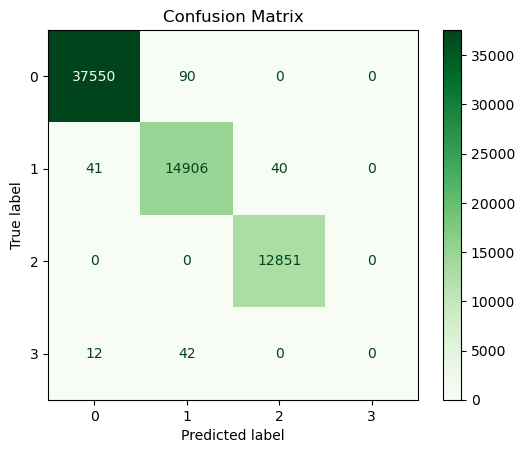

In [27]:
best_model_sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1E-8, learning_rate='optimal', shuffle=True, random_state=42, max_iter=1000, n_jobs=-1, early_stopping=True, validation_fraction=0.1)
best_model_sgd.fit(encoded_features_df, y_encoded)
best_model_sgd.predict(encoded_features_df)
best_model_sgd.score(encoded_features_df, y_encoded)

# Perform cross-validation
cv_scores = cross_val_score(best_model_sgd, encoded_features_df, y_encoded, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean CV score: {:.4f}".format(cv_scores.mean()))

best_model_sgd.fit(encoded_features_df, y_encoded)

# Make predictions on the test set
y_pred = best_model_sgd.predict(encoded_features_df)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_encoded, y_pred))

# Create and display the confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_encoded, y_pred, cmap='Greens')
plt.title(f'Confusion Matrix')
plt.show()